In [1]:
import glob
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [3]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob("/Users/n.anokhin/Desktop/data/*/data.json")
])
data["rnd"] = np.random.random(len(data))

data.head(10)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2024-02-19 07:56:30.469,5650,16053,0.80,0.021466,1817.0,{'STICKY_ARTIST': 'T2'},0.374540
1,next,2024-02-19 07:56:30.504,5100,18840,0.45,0.002275,708.0,{'STICKY_ARTIST': 'T1'},0.950714
2,next,2024-02-19 07:56:30.534,6269,9804,0.00,0.001347,49810.0,{'STICKY_ARTIST': 'T1'},0.731994
3,next,2024-02-19 07:56:30.554,771,525,1.00,0.000751,49387.0,{'STICKY_ARTIST': 'T3'},0.598658
4,next,2024-02-19 07:56:30.573,771,49387,0.02,0.001765,1873.0,{'STICKY_ARTIST': 'T3'},0.156019
5,next,2024-02-19 07:56:30.600,5189,42637,0.00,0.002580,33839.0,{'STICKY_ARTIST': 'T1'},0.155995
6,next,2024-02-19 07:56:30.626,776,6700,0.11,0.007986,6700.0,{'STICKY_ARTIST': 'T2'},0.058084
7,next,2024-02-19 07:56:30.647,5189,42637,0.00,0.001250,19019.0,{'STICKY_ARTIST': 'T1'},0.866176
8,next,2024-02-19 07:56:30.662,771,47457,0.03,0.002788,49023.0,{'STICKY_ARTIST': 'T3'},0.601115
9,last,2024-02-19 07:56:30.679,771,47457,0.00,0.000254,NaN,{'STICKY_ARTIST': 'T3'},0.708073


## Compute track popularity

In [4]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,5,52.38
1,952,52.04
2,4363,49.02
3,16,47.00
4,440,46.00


In [5]:
len(track_popularity)

38310

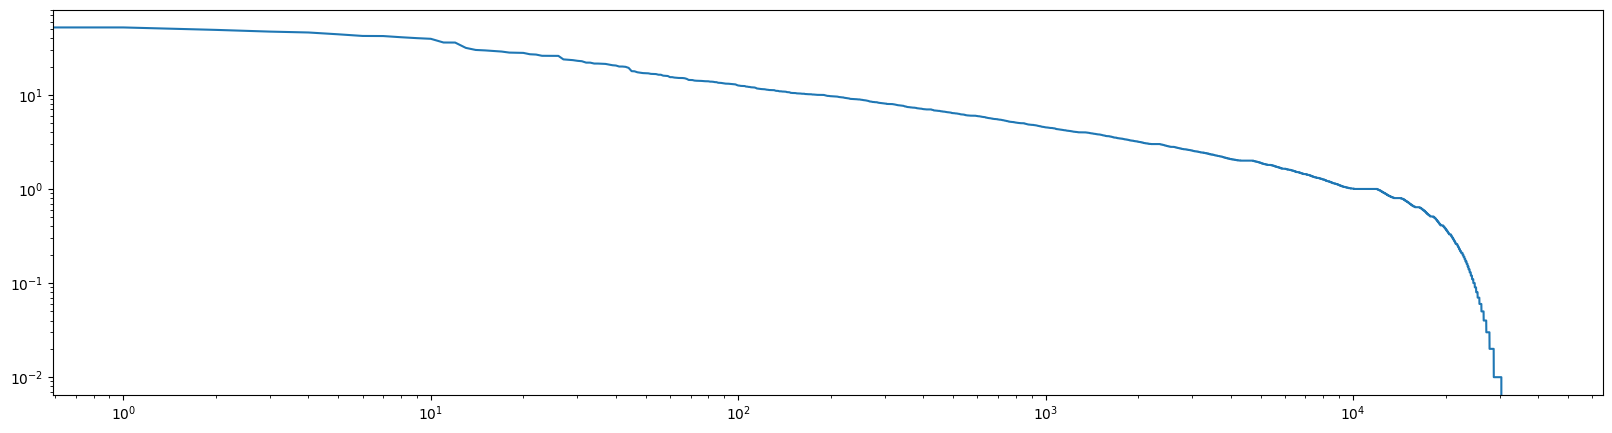

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

ax.set_xscale("log")
ax.set_yscale("log")

pass

## Compute offline metrics

In [8]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [9]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,23500.000000,23500.000000,23500.000000,23500.000000
mean,0.001685,0.001685,0.000736,0.000200
std,0.012872,0.012872,0.008549,0.004468
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


In [12]:
def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [13]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,23500.000000,23500.000000,23500.000000,23500.000000
mean,0.008048,0.004857,0.003732,0.002011
std,0.055361,0.050513,0.033212,0.023033
min,0.000000,0.000000,0.000000,0.000000
25%,0.000056,0.000000,0.000000,0.000000
50%,0.000188,0.000000,0.000000,0.000000
75%,0.000928,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## Export data for prod

In [14]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)

In [16]:
track_popularity["track"].tolist()

[5,
 952,
 4363,
 16,
 440,
 4450,
 84,
 12,
 401,
 83,
 59,
 3224,
 3765,
 4081,
 78,
 3221,
 15,
 544,
 481,
 0,
 525,
 4460,
 2,
 11,
 2899,
 3999,
 2131,
 559,
 68,
 496,
 3220,
 1888,
 1886,
 4961,
 552,
 125,
 768,
 1,
 3343,
 491,
 503,
 1123,
 1117,
 1881,
 526,
 1891,
 487,
 199,
 409,
 1878,
 494,
 85,
 2015,
 1697,
 8492,
 4136,
 211,
 1107,
 4331,
 5125,
 530,
 1126,
 2180,
 188,
 465,
 2000,
 5410,
 3805,
 523,
 484,
 1616,
 567,
 1745,
 1473,
 248,
 64,
 2618,
 1893,
 492,
 475,
 485,
 11952,
 3348,
 4499,
 208,
 553,
 514,
 4686,
 55,
 1022,
 498,
 587,
 497,
 486,
 5737,
 8054,
 6205,
 542,
 863,
 2616,
 3797,
 2037,
 3125,
 1387,
 718,
 540,
 489,
 4329,
 281,
 2962,
 441,
 545,
 6481,
 509,
 1511,
 1322,
 751,
 2887,
 508,
 4524,
 2069,
 566,
 414,
 3111,
 15087,
 3466,
 568,
 870,
 1499,
 1109,
 6221,
 314,
 6438,
 294,
 3583,
 77,
 2233,
 1370,
 1866,
 22970,
 2432,
 1629,
 3088,
 1100,
 4529,
 3584,
 22962,
 1115,
 547,
 22961,
 190,
 9319,
 6666,
 515,
 8349,
 275